In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import nltk

# libraries for data preprocessing and feature selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from scipy.stats import chi2_contingency
from nltk.corpus import stopwords

# cross-validation and model construction
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [44]:
# load data from csv files
train_data = pd.read_csv("project_data/train_dataset.csv")
test_data = pd.read_csv("project_data/test_dataset.csv")

In [45]:
def group_years(y):
    start_year = (y // 10) * 10
    end_year = ((y // 10) * 10) + 9
    return f"{start_year} - {end_year}"

def preprocessing(data):
    
    # Normalizing features with continuous data using min max scaling
    id = data["id"].copy().to_numpy()
    num_critic_for_review = data["num_critic_for_reviews"].copy().to_numpy().astype(int)
    duration = data["duration"].copy().to_numpy().astype(int)
    director_likes = data["director_facebook_likes"].copy().to_numpy().astype(int)
    actor3_likes = data["actor_3_facebook_likes"].copy().to_numpy().astype(int)
    actor1_likes = data["actor_1_facebook_likes"].copy().to_numpy().astype(int)
    gross = data["gross"].copy().to_numpy().astype(int)
    num_voted_users = data["num_voted_users"].copy().to_numpy().astype(int)
    cast_total_facebook_likes = data["cast_total_facebook_likes"].copy().to_numpy().astype(int)
    facenumber_in_poster = data["facenumber_in_poster"].copy().to_numpy().astype(int)
    num_user_for_reviews = data["num_user_for_reviews"].copy().to_numpy().astype(int)
    actor_2_facebook_likes = data["actor_2_facebook_likes"].copy().to_numpy().astype(int)
    movie_facebook_likes = data["movie_facebook_likes"].copy().to_numpy().astype(int)
    average_degree_centrality = data["average_degree_centrality"].copy().to_numpy().astype(np.double)
    
    normalize = MinMaxScaler()
    num_critic_for_review = normalize.fit_transform(num_critic_for_review.reshape(-1, 1)).flatten()
    duration = normalize.fit_transform(duration.reshape(-1, 1)).flatten()
    director_likes = normalize.fit_transform(director_likes.reshape(-1, 1)).flatten()
    actor3_likes = normalize.fit_transform(actor3_likes.reshape(-1, 1)).flatten()
    actor1_likes = normalize.fit_transform(actor1_likes.reshape(-1, 1)).flatten()
    gross = normalize.fit_transform(gross.reshape(-1, 1)).flatten()
    num_voted_users = normalize.fit_transform(num_voted_users.reshape(-1, 1)).flatten()
    cast_total_facebook_likes = normalize.fit_transform(cast_total_facebook_likes.reshape(-1, 1)).flatten()
    facenumber_in_poster = normalize.fit_transform(facenumber_in_poster.reshape(-1, 1)).flatten()
    num_user_for_reviews = normalize.fit_transform(num_user_for_reviews.reshape(-1, 1)).flatten()
    actor_2_facebook_likes = normalize.fit_transform(actor_2_facebook_likes.reshape(-1, 1)).flatten()
    movie_facebook_likes = normalize.fit_transform(movie_facebook_likes.reshape(-1, 1)).flatten()
    average_degree_centrality = normalize.fit_transform(average_degree_centrality.reshape(-1, 1)).flatten()
    
    data.drop(columns=["num_critic_for_reviews"], inplace=True) 
    data.insert(loc=2, column='num_critic_for_reviews', value=num_critic_for_review)
    data.drop(columns=["duration"], inplace=True) 
    data.insert(loc=3, column='duration', value=duration)
    data.drop(columns=["director_facebook_likes"], inplace=True) 
    data.insert(loc=4, column='director_facebook_likes', value=director_likes)
    data.drop(columns=["actor_3_facebook_likes"], inplace=True) 
    data.insert(loc=5, column='actor_3_facebook_likes', value=actor3_likes)
    data.drop(columns=["actor_1_facebook_likes"], inplace=True) 
    data.insert(loc=7, column='actor_1_facebook_likes', value=actor1_likes)
    data.drop(columns=["gross"], inplace=True) 
    data.insert(loc=8, column='gross', value=gross)
    data.drop(columns=["num_voted_users"], inplace=True) 
    data.insert(loc=12, column='num_voted_users', value=num_voted_users)
    data.drop(columns=["cast_total_facebook_likes"], inplace=True) 
    data.insert(loc=13, column='cast_total_facebook_likes', value=cast_total_facebook_likes)
    data.drop(columns=["facenumber_in_poster"], inplace=True) 
    data.insert(loc=15, column='facenumber_in_poster', value=facenumber_in_poster)
    data.drop(columns=["num_user_for_reviews"], inplace=True) 
    data.insert(loc=17, column='num_user_for_reviews', value=num_user_for_reviews)
    data.drop(columns=["actor_2_facebook_likes"], inplace=True) 
    data.insert(loc=22, column='actor_2_facebook_likes', value=actor_2_facebook_likes)
    data.drop(columns=["movie_facebook_likes"], inplace=True) 
    data.insert(loc=23, column='movie_facebook_likes', value=movie_facebook_likes)
    data.drop(columns=["average_degree_centrality"], inplace=True) 
    data.insert(loc=25, column='average_degree_centrality', value=average_degree_centrality)


    # One-hot encoding for categorical data
    language = data["language"]
    country = data["country"]
    content_rating = data["content_rating"]
    genres = data["genres"].str.split('|', expand=True)
    plot_keywords = data["plot_keywords"].str.split('|', expand=True)
    director_name = data["director_name"]
    actor_1_name = data["actor_1_name"] 
    actor_2_name = data["actor_2_name"] 
    actor_3_name = data["actor_3_name"]
    year_group = data["title_year"].apply(group_years)
    movie_title = data["movie_title"].str.split(' ', expand=True)

    language = pd.get_dummies(language).astype(int)
    country = pd.get_dummies(country).astype(int)
    content_rating = pd.get_dummies(content_rating).astype(int)
    genres = pd.get_dummies(genres, prefix='', prefix_sep='')
    genres = genres.groupby(genres.columns, axis=1).sum()

    plot_keywords = pd.get_dummies(plot_keywords, prefix='', prefix_sep='')
    plot_keywords = plot_keywords.groupby(plot_keywords.columns, axis=1).sum()
    plot_keywords_counts = plot_keywords.sum()
    sorted_plot_keywords_counts = plot_keywords_counts.sort_values(ascending=False)
    top_200_plot_keywords = sorted_plot_keywords_counts.head(200)
    plot_keywords = plot_keywords[top_200_plot_keywords.index]
    director_name = pd.get_dummies(director_name).astype(int)
    director_name_counts = director_name.sum()
    sorted_director_name_counts = director_name_counts.sort_values(ascending=False)
    top_200_director_name = sorted_director_name_counts.head(200)
    director_name = director_name[top_200_director_name.index]

    actor_1_name = pd.get_dummies(actor_1_name).astype(int)
    actor_2_name = pd.get_dummies(actor_2_name).astype(int)
    actor_3_name = pd.get_dummies(actor_3_name).astype(int)
    actor_name = pd.concat([actor_1_name, actor_2_name, actor_3_name], axis=1)
    actor_name = actor_name.groupby(actor_name.columns, axis=1).max()
    actor_name_counts = actor_name.sum()
    sorted_actor_name_counts = actor_name_counts.sort_values(ascending=False)
    top_300_actor_name = sorted_actor_name_counts.head(400)
    actor_name = actor_name[top_300_actor_name.index]

    # group title_year with a decade as a group
    year_group = pd.get_dummies(year_group).astype(int)

    # remove stopwords in move titles
    movie_title = pd.get_dummies(movie_title, prefix='', prefix_sep='')
    movie_title = movie_title.groupby(movie_title.columns, axis=1).sum()
    nltk.download('stopwords')
    stopword = set(stopwords.words('english'))
    for col in movie_title.columns:
        if col.lower() in stopword:
            movie_title.drop(col, axis=1, inplace=True)
    movie_title_counts = movie_title.sum()
    sorted_movie_title_counts = movie_title_counts.sort_values(ascending=False)
    top_200_movie_title = sorted_movie_title_counts.head(200)
    movie_title = movie_title[top_200_movie_title.index]   

    # drop columns preprocessed by one-hot encoding
    data.drop(columns=["language"], inplace=True)
    data.drop(columns=["country"], inplace=True)
    data.drop(columns=["content_rating"], inplace=True)
    data.drop(columns=["genres"], inplace=True)
    data.drop(columns=["plot_keywords"], inplace=True)
    data.drop(columns=["director_name"], inplace=True)
    data.drop(columns=["actor_1_name"], inplace=True)
    data.drop(columns=["actor_2_name"], inplace=True)
    data.drop(columns=["actor_3_name"], inplace=True)
    data.drop(columns=["title_year"], inplace=True)
    data.drop(columns=["movie_title"], inplace=True)
    data = pd.concat([data, language, country, content_rating, genres, plot_keywords, director_name, actor_name, year_group, movie_title], axis=1)

    
    data.drop(columns=["title_embedding"], inplace=True)
    
    data.drop(columns = ["id"], inplace=True)

    # combine and remove duplicates
    dup_col = data.columns[data.columns.duplicated()].tolist()
    for i in range (len(dup_col)):
        merge_col = data[dup_col[i]].max(axis=1)
        data.drop(columns=[dup_col[i]], inplace=True)
        data[dup_col[i]] = merge_col

    
    return data


In [46]:
preprocessed_data = preprocessing(train_data)
preprocessed_data.to_csv('output.csv', index=False)

y_train = preprocessed_data["imdb_score_binned"]
x_train = preprocessed_data
x_train.drop(columns=["imdb_score_binned"], inplace=True)
print("There are", len(x_train.columns), "features and", x_train.shape[0], "instances.")

[nltk_data] Downloading package stopwords to /Users/qcok/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


There are 1126 features and 3004 instances.


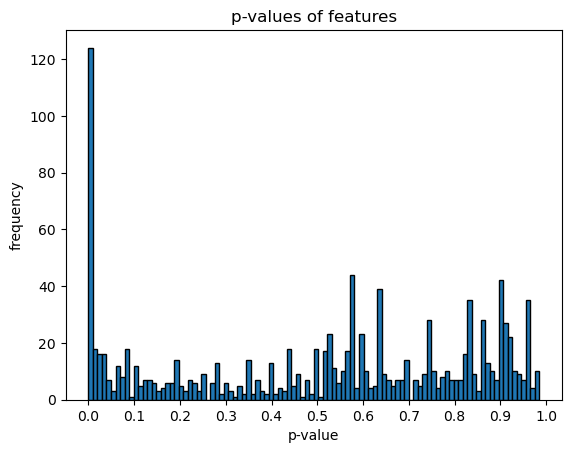

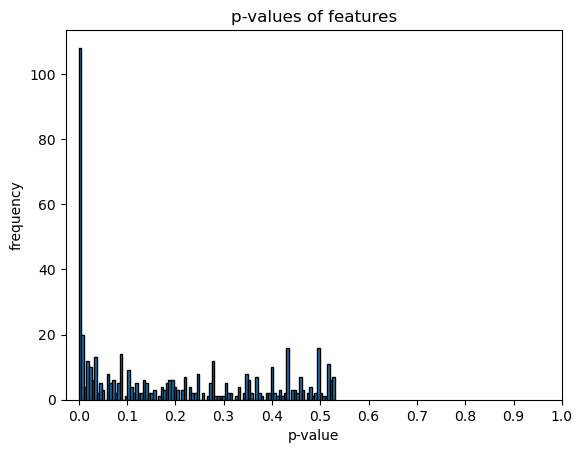

In [47]:
feature_names = x_train.columns.tolist()

# Calculate chi2 scores and p-values for all features
chi2_scores, p_values = chi2(x_train, y_train)
plot.hist(p_values, edgecolor = 'black', bins=100)
plot.xlabel('p-value')
plot.ylabel('frequency')
plot.title("p-values of features")
plot.xticks(np.arange(0,1.1,0.1))
plot.show()

# select 500 best features
select = SelectKBest(score_func=chi2, k=500)
x_train_new = select.fit_transform(x_train, y_train)
chi2_scores, p_values = chi2(x_train_new, y_train)
plot.hist(p_values, edgecolor = 'black', bins=100)
plot.xlabel('p-value')
plot.ylabel('frequency')
plot.title("p-values of features")
plot.xticks(np.arange(0,1.1,0.1))
plot.show()

# obtain features selected
selected_feature_indices = select.get_support(indices=True)
selected_feature_names = pd.DataFrame(x_train_new, columns=[feature_names[i] for i in selected_feature_indices])
selected_feature_names = selected_feature_names.columns.tolist()


In [48]:
# preprocess test data
id_column = test_data["id"].copy().to_numpy().astype(int)
x_test = preprocessing(test_data)

x_test = x_test.reindex(columns=selected_feature_names, fill_value=0)

[nltk_data] Downloading package stopwords to /Users/qcok/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy score:  0.7313581890812251


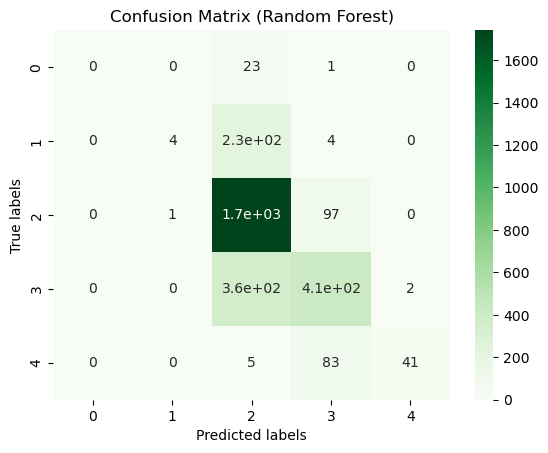

In [30]:
# 5-fold cross-validation using random forest
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# code used for manual hypermeter tuning
rf = RandomForestClassifier(random_state=0, n_estimators=200, max_depth=100)
y_test_val_pred = cross_val_predict(rf, x_train_new, y_train, cv=kfold)
print('Accuracy score: ', accuracy_score(y_train, y_test_val_pred))

# confusion matrix of validation results
matrix = confusion_matrix(y_train, y_test_val_pred)
sns.heatmap(matrix, annot=True, cmap='Greens')
plot.title('Confusion Matrix (Random Forest)')
plot.xlabel('Predicted labels')
plot.ylabel('True labels')
plot.show()


In [34]:
# random forest
rf = RandomForestClassifier(random_state=0, n_estimators=200, max_depth=100)
rf.fit(x_train_new, y_train)
y_test = rf.predict(x_test)

# load model results into csv file
y_test_pd = pd.DataFrame(y_test, columns=['imdb_score_binned'])
y_test_pd.insert(loc=0, column='id', value=id_column)
y_test_pd.to_csv('rf_prediction.csv', index=False)

/Users/qcok/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


/Users/qcok/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/qcok/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Accuracy score:  0.7113848202396804


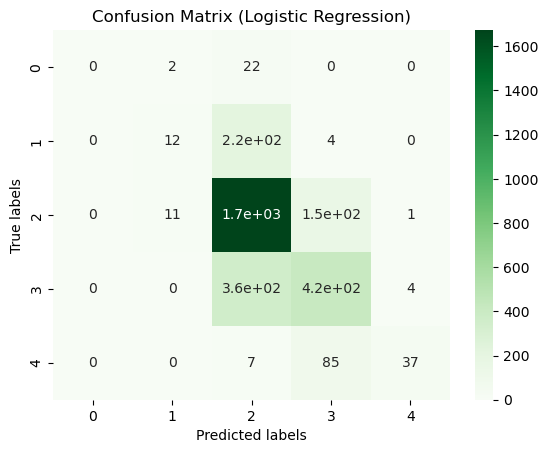

In [52]:
# 5-fold cross-validation using logistic regression
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# code used for manual hypermeter tuning
lr = LogisticRegression(C=0.5, penalty='l2')
y_test_val_pred = cross_val_predict(lr, x_train_new, y_train, cv=kfold)
print('Accuracy score: ', accuracy_score(y_train, y_test_val_pred))

# confusion matrix
matrix = confusion_matrix(y_train, y_test_val_pred)
sns.heatmap(matrix, annot=True, cmap='Greens')
plot.title('Confusion Matrix (Logistic Regression)')
plot.xlabel('Predicted labels')
plot.ylabel('True labels')
plot.show()

In [50]:
# logistic regression
lr = LogisticRegression(C=0.5, penalty='l2')
lr.fit(x_train_new, y_train)
y_test = lr.predict(x_test)

# load model results into csv file
y_test_pd = pd.DataFrame(y_test, columns=['imdb_score_binned'])
y_test_pd.insert(loc=0, column='id', value=id_column)
y_test_pd.to_csv('lr_prediction.csv', index=False)

/Users/qcok/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/qcok/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


/Users/qcok/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/qcok/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/qcok/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/qcok/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/qcok/anaconda3/lib/py

Accuracy score:  0.6954061251664447


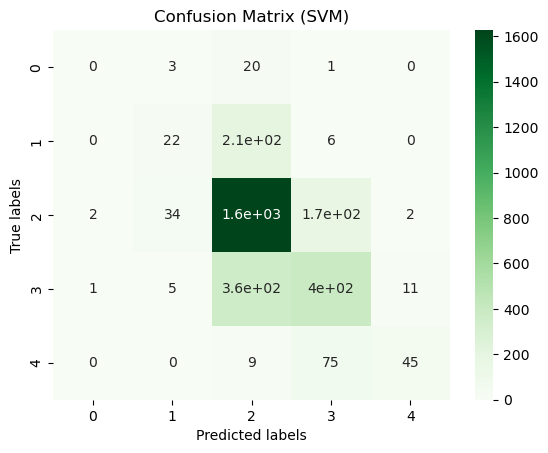

In [59]:
# 5-fold cross-validation using linear svm
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# code used for manual hypermeter tuning
svm = LinearSVC(C=0.25)
y_test_val_pred = cross_val_predict(svm, x_train_new, y_train, cv=kfold)
print('Accuracy score: ', accuracy_score(y_train, y_test_val_pred))

# confusion matrix
matrix = confusion_matrix(y_train, y_test_val_pred)
sns.heatmap(matrix, annot=True, cmap='Greens')
plot.title('Confusion Matrix (SVM)')
plot.xlabel('Predicted labels')
plot.ylabel('True labels')
plot.show()

In [61]:
# Linear SVM
svm = LinearSVC(C=0.25)
svm.fit(x_train_new, y_train)
y_test = svm.predict(x_test)

# load model results into csv file
y_test_pd = pd.DataFrame(y_test, columns=['imdb_score_binned'])
y_test_pd.insert(loc=0, column='id', value=id_column)
y_test_pd.to_csv('svm_prediction.csv', index=False)

/Users/qcok/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/qcok/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(
